In [1]:
pip install tensorflow opencv-python matplotlib


Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50  # ResNet-18 is not directly available, so we use ResNet-50 and adjust.
from tensorflow.keras.optimizers import Adam
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Paths for raw images and ulcer labels
IMG_DIR = "/kaggle/input/raw-images"  # Replace with the URL or local path of raw images
LABEL_DIR = "/kaggle/input/ulcerlabels"  # Replace with the URL or local path of ulcer labels

# Hyperparameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 50

In [3]:
pip install tensorflow-gpu


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_vendor/packaging/_parser.py", line 126, in _parse_requirement_details
          marker = _parse_requirement_marker(
        File 

In [4]:
import tensorflow as tf

In [5]:
def load_data(img_dir, label_dir):
    images = []
    labels = []
    
    # List all files in the image directory
    img_files = sorted(os.listdir(img_dir))
    
    for img_file in img_files:
        # Get the base name (remove the extension) from the image filename
        base_name = os.path.splitext(img_file)[0]
        
        # Construct the corresponding label filename by adding '.png' extension
        label_file = base_name + ".png"
        
        # Build the full paths
        img_path = os.path.join(img_dir, img_file)
        label_path = os.path.join(label_dir, label_file)
        
        # Read and preprocess image
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error loading image: {img_path}")
            continue
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        images.append(img)
        
        # Read and preprocess label
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)  # Read label as grayscale (binary image)
        if label is None:
            print(f"Error loading label: {label_path}")
            continue
        label = cv2.resize(label, (IMG_WIDTH, IMG_HEIGHT))
        label = np.expand_dims(label, axis=-1)  # Add channel dimension
        labels.append(label)
    
    images = np.array(images) / 255.0  # Normalize images to [0, 1]
    labels = np.array(labels) / 255.0  # Normalize labels to [0, 1] (binary)
    labels = (labels > 0.5).astype(np.float32)  # Binarize labels (0 or 1)
    return images, labels

In [8]:
# Load the dataset
images, labels = load_data(IMG_DIR, LABEL_DIR)

# Split dataset into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Define the U-Net model with ResNet50 as the encoder
def unet_with_resnet(input_shape):
    # Load the pre-trained ResNet50 model without the top (classification) layers
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the layers of ResNet to prevent updating during training
    for layer in resnet.layers:
        layer.trainable = False
    
    # Encoder: ResNet50 as the feature extractor
    encoder_output = resnet.output
    
    # Decoder: Upsample and concatenate with encoder layers
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(encoder_output)
    u6 = concatenate([u6, resnet.get_layer("conv4_block6_out").output])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, resnet.get_layer("conv3_block4_out").output])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, resnet.get_layer("conv2_block3_out").output])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, resnet.get_layer("conv1_relu").output])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Fix: Upscale the skip connection to match the output size
    u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
    # Use UpSampling2D to resize the skip connection to match the output size (224x224)
    skip_connection_resized = UpSampling2D(size=(2, 2), interpolation='bilinear')(resnet.get_layer("conv1_relu").output)
    u10 = concatenate([u10, skip_connection_resized])  # Concatenate after resizing

    # Output layer (ensure the output size matches input size: 224x224x1)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u10)

    model = Model(inputs=resnet.input, outputs=outputs)
    return model


In [9]:
model = unet_with_resnet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/50


I0000 00:00:1733552959.179640      98 service.cc:145] XLA service 0x786a5c003790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733552959.179701      98 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733552959.179705      98 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733552982.111603      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9658 - loss: 0.1805 - val_accuracy: 0.9690 - val_loss: 0.1366
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.9682 - loss: 0.1308 - val_accuracy: 0.9690 - val_loss: 0.1064
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.9712 - loss: 0.0992 - val_accuracy: 0.9690 - val_loss: 0.1010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.9706 - loss: 0.0964 - val_accuracy: 0.9690 - val_loss: 0.0947
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - accuracy: 0.9661 - loss: 0.1078 - val_accuracy: 0.9690 - val_loss: 0.0948
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - accuracy: 0.9680 - loss: 0.1010 - val_accuracy: 0.9690 - val_loss: 0.0926
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.9677 - loss: 0.0979 - val_accuracy: 0.9690 - val_loss: 0.0928
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.9684 - loss: 0.0946 - val_accuracy: 0.9690 - val_lo

In [10]:
def predict_and_visualize(image, model):
    img = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT)) / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)[0, :, :, 0]
    prediction = (prediction > 0.5).astype(np.uint8)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(prediction, cmap="gray")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


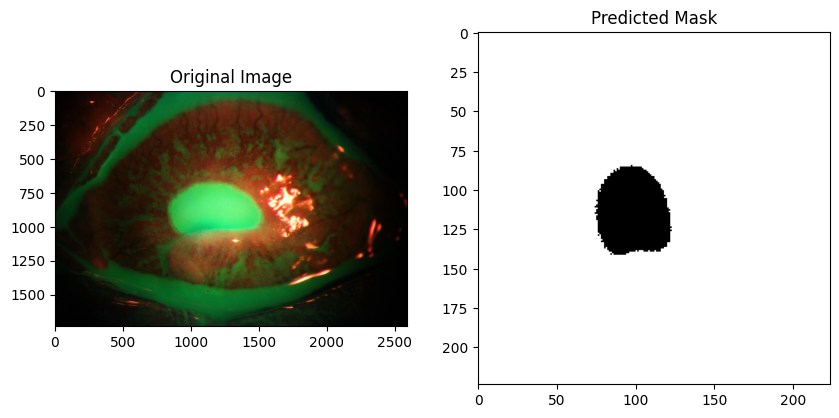

In [11]:
# Example usage
sample_image = cv2.imread("/kaggle/input/test-input/359.jpg")
predict_and_visualize(sample_image, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


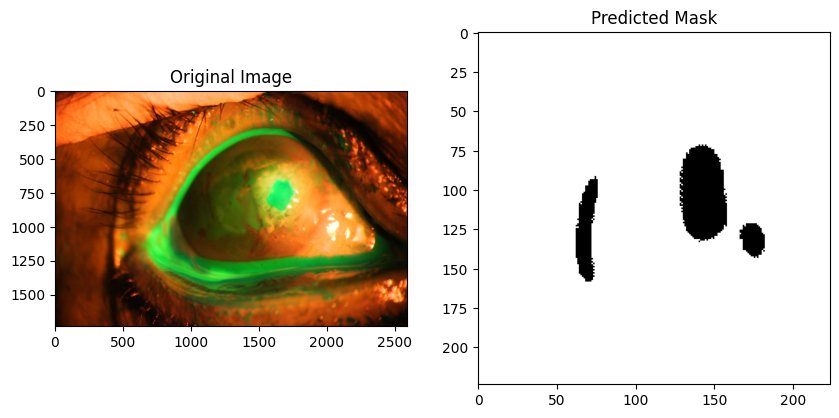

In [12]:
sample_image = cv2.imread("/kaggle/input/test-input/360.jpg")
predict_and_visualize(sample_image, model)

In [13]:
from sklearn.metrics import confusion_matrix

def calculate_metrics(y_true, y_pred):
    # Flatten the masks to 1D for simplicity
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    # Binarize predictions (threshold at 0.5)
    y_pred = (y_pred > 0.5).astype(np.uint8)
    
    # Calculate confusion matrix elements
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    
    # Global accuracy
    global_accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # Sensitivity
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    
    # Jaccard Similarity
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    jaccard_similarity = intersection / union if union > 0 else 0.0
    
    # Dice Similarity Coefficient
    dice_similarity = (2 * intersection) / (np.sum(y_true) + np.sum(y_pred)) if (np.sum(y_true) + np.sum(y_pred)) > 0 else 0.0
    
    return global_accuracy, sensitivity, jaccard_similarity, dice_similarity

# Calculate metrics for all test images
global_accuracies = []
sensitivities = []
jaccard_similarities = []
dice_similarities = []

for i in range(len(x_test)):
    # Predict the mask for a test image
    pred_mask = model.predict(np.expand_dims(x_test[i], axis=0))[0, :, :, 0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Binarize prediction
    
    # Ground truth mask
    true_mask = y_test[i, :, :, 0]
    
    # Compute metrics
    metrics = calculate_metrics(true_mask, pred_mask)
    global_accuracies.append(metrics[0])
    sensitivities.append(metrics[1])
    jaccard_similarities.append(metrics[2])
    dice_similarities.append(metrics[3])

# Compute average metrics
print(f"Global Accuracy: {np.mean(global_accuracies):.4f}")
print(f"Sensitivity: {np.mean(sensitivities):.4f}")
print(f"Jaccard Similarity: {np.mean(jaccard_similarities):.4f}")
print(f"Dice Similarity: {np.mean(dice_similarities):.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━